In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import pandas as pd
from netneurotools import metrics 
import seaborn as sns
import pingouin as pg

from src import data
from scipy import signal

from sklearn import metrics as sk_metrics

%matplotlib widget

!date -I

2024-03-18


In [2]:
def plot_data(data,title=None):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.figure()
    plt.plot(data);
    plt.title(title)
    plt.show()

def plot_one_roi(data,roi_id,labels,title=None,constants_h=[],constants_v=[]):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.figure()
    plt.plot(data[:,roi_id])
    for c in constants_h:
        plt.plot([c]*400,color="r")
    for c in constants_v:
        plt.vlines(c, np.min(data), np.max(data),color="r")
    plt.title(labels[roi_id])
    plt.show()

## Load data

### Load pytepfit data

In [3]:
empirical_or_simulated = 'empirical'
pytepfit_path = 'external/pytepfit/'
data_pytepfit = np.load(data.path(f'{pytepfit_path}source_estimates/{empirical_or_simulated}.npz'))
data_pytepfit['ts'].shape

(400, 200)

In [4]:
data_pytepfit['labels'][:10]

array(['7Networks_LH_Cont_Cing_1-lh', '7Networks_LH_Cont_Cing_2-lh',
       '7Networks_LH_Cont_PFCl_1-lh', '7Networks_LH_Cont_PFCl_2-lh',
       '7Networks_LH_Cont_PFCl_3-lh', '7Networks_LH_Cont_PFCl_4-lh',
       '7Networks_LH_Cont_PFCl_5-lh', '7Networks_LH_Cont_PFCl_6-lh',
       '7Networks_LH_Cont_Par_1-lh', '7Networks_LH_Cont_Par_2-lh'],
      dtype='<U40')

In [5]:
data_pytepfit['labels'].shape

(200,)

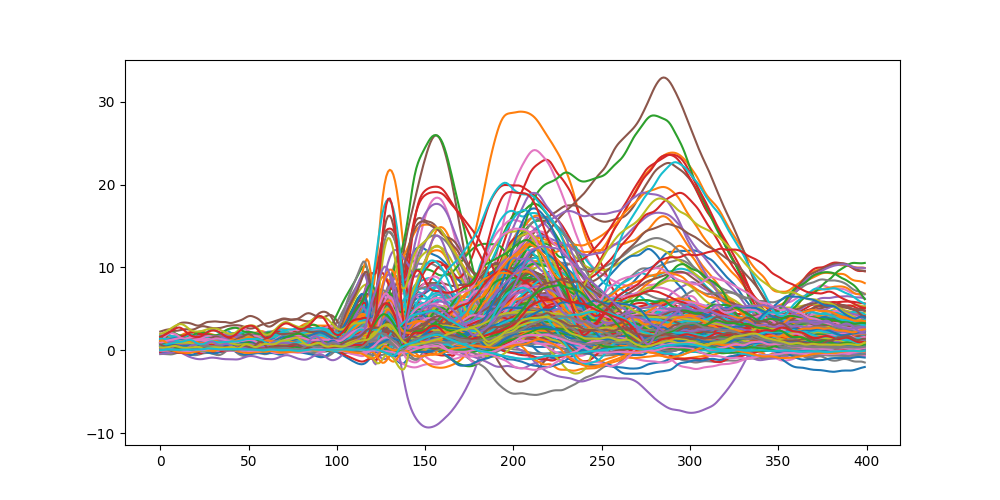

In [6]:
data_ts = data_pytepfit['ts']
plot_data(data_ts)

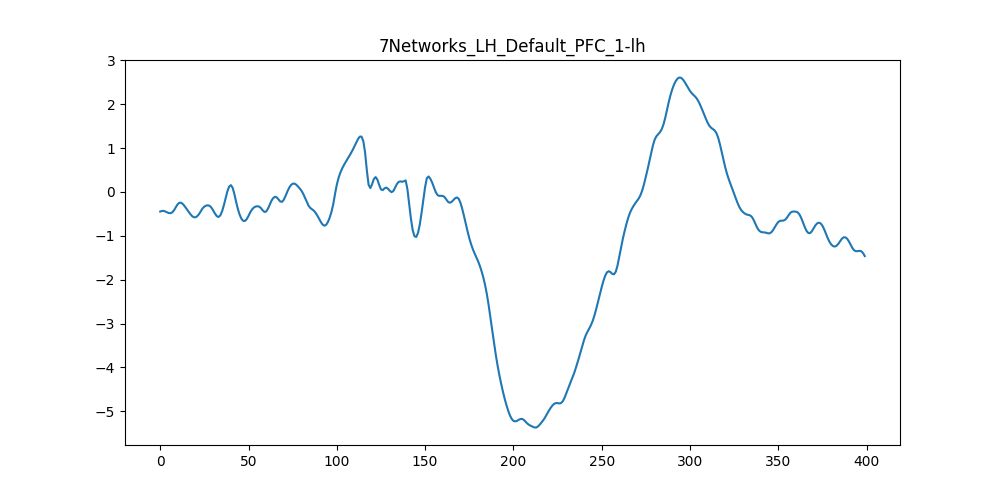

In [7]:
plot_one_roi(data_ts,17,data_pytepfit['labels'])

In [8]:
def peak_analysis(sequence,threshold):
    peaks = signal.find_peaks(sequence,height=threshold)

    if len(peaks[0]) == 0:
        return np.nan, np.nan, np.nan, np.nan

    first_peak_time = peaks[0][0]
    first_peak_height = peaks[1]['peak_heights'][0]
    max_peak_time = peaks[0][np.argmax(peaks[1]['peak_heights'])]
    max_peak_height = np.max(peaks[1]['peak_heights'])

    return first_peak_time, first_peak_height, max_peak_time, max_peak_height

def estimate_auc(seqence, threshold):
    estimate = 0

    for v in seqence:
        if v > threshold:
            estimate += v

    if estimate > 0:
        return estimate

    return None
    

def get_threshold_range(corrected_data,stim_idx):
    maxima = np.max(data_ts[stim_idx:,:],axis=0)
    maxima.sort()

    upper = int(maxima[-5])
    lower = int(np.max(corrected_data[:stim_idx,:]))
    step = int((upper - lower) / 7)

    return range(lower, upper, step)

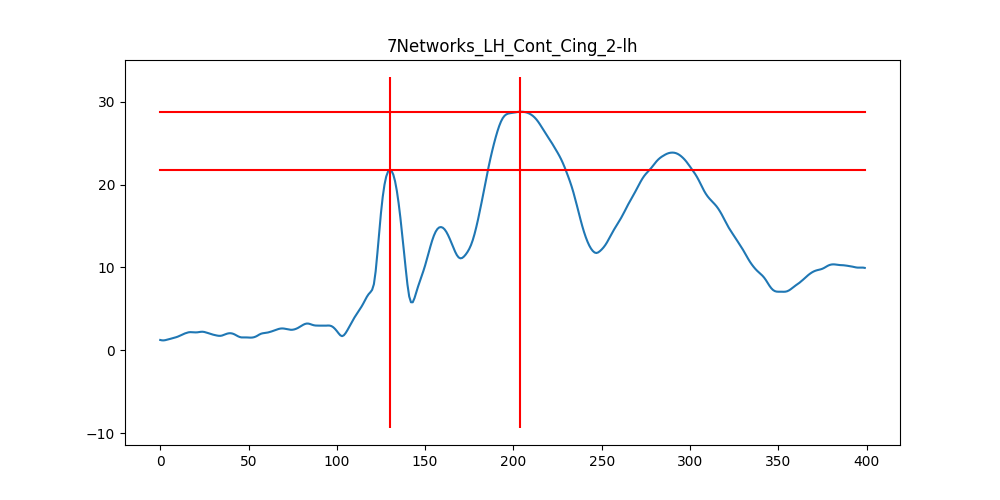

In [9]:
roi_idx = 1

amp_id, amp, amp_h_id, amp_h = peak_analysis(data_ts[:,roi_idx],threshold=5)

plot_one_roi(data_ts,roi_idx,labels=data_pytepfit['labels'],constants_h=[amp,amp_h],constants_v=[amp_id,amp_h_id])

In [10]:
responses = {} 
stim_time = 100

df_responses = pd.DataFrame()

thr_range = get_threshold_range(data_ts,stim_time)


# sklearn.metrics.auc(x, y)

for threshold in thr_range:

    response_df = pd.DataFrame(index=range(200))

    response_df['01-response'] =  np.max(data_ts,axis=0) > threshold

    peak_analysis_results = np.zeros((200,4),dtype=float)
    for i in range(200):
        peak_analysis_results[i] = peak_analysis(data_ts[stim_time:,i],threshold)

    response_df['first_peak'] = peak_analysis_results[:,0]
    response_df['first_peak_time'] = peak_analysis_results[:,1]
    response_df['highest_peak'] = peak_analysis_results[:,2]
    response_df['highest_peak_time'] = peak_analysis_results[:,3]

    response_df['variance'] = np.var(data_ts[stim_time:],axis=0)
    response_df['diff'] = np.max(data_ts[stim_time:],axis=0)-np.min(data_ts[stim_time:],axis=0)

    response_df['AUC'] = np.array([sk_metrics.auc(list(range(len(data_ts[stim_time:,i]))), data_ts[stim_time:,i]) for i in range(200)],dtype=float)
    response_df['AUC_curve_above_thr'] = np.array([sk_metrics.auc(list(range(len(data_ts[stim_time:,i]))), (data_ts[stim_time:,i]-threshold).clip(min=0)) for i in range(200)],dtype=float)
    response_df['mean'] = np.array([np.mean(data_ts[stim_time:,i]) for i in range(200)],dtype=float)
    response_df['power'] = np.array([np.sum(data_ts[stim_time:,i]**2) for i in range(200)],dtype=float)

    for c in ['variance','diff','AUC','AUC_curve_above_thr','mean','power']:
        response_df[c] = np.where(response_df['01-response'],response_df[c],np.nan)

    responses[threshold] = response_df

In [11]:
def prepare_barcode(n_rows,n_cols,title=None):
    pixel_per_bar = 6
    dpi = 100

    fig, ax = plt.subplots(n_rows, 1, figsize=(n_cols * pixel_per_bar / dpi, n_rows/1.5), dpi=dpi, sharex=True)
    fig.suptitle(title)
    fig.subplots_adjust(right=0.7)

    return fig, ax

def plot_one_barcode(ax,data,title=None):

    if not isinstance(data, np.ndarray):
        code = data.to_numpy().reshape(1,-1).astype(float)
    else:
        code = data.reshape(1,-1).astype(float)

    ax.imshow(code, cmap='binary', aspect='auto',
          interpolation='nearest')
    ax.set_title(f"  {title}", loc="right", y=0, ha="left", va="center")
    ax.set_yticks([])

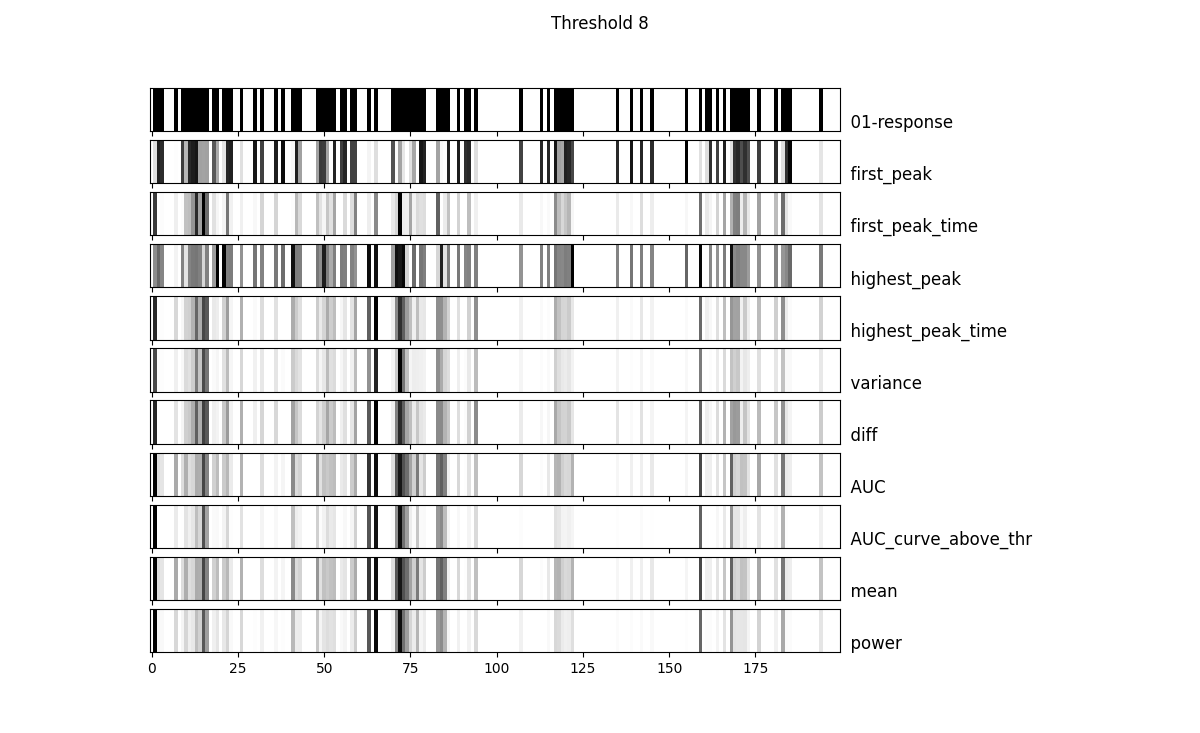

In [12]:
thr = list(responses.keys())[2]

fig, axs = prepare_barcode(len(responses[thr].columns),200,title=f"Threshold {thr}")

for i,c in enumerate(responses[thr].columns):
    plot_one_barcode(axs[i],responses[thr][c],title=c)

In [13]:
stim_locatin = 85 # FIXME

### Load structural (and functional) connectivity data

In [14]:
SC_W, SC_L, _ = data.load_pytepfit_sc()
SC_W_alt = np.load("test.npy")
SC_W_ENIGMA, _, FC_ENIGMA = data.load_enigma(parcellation="schaefer_200",reoreder='PyTepFit')
SC_W_dom, SC_L_dom, FC_dom = data.load_domhof_for_pytepfit()

In [15]:
centroids_file = data.path('external/schaefer_parcellation_centroids/ROI_MAPPING_pytepfit.csv')
centroids_mne = data.get_centroids_from_file(centroids_file,"geom_mne")

ED = data.roi_distances_from_centroids(centroids_mne)

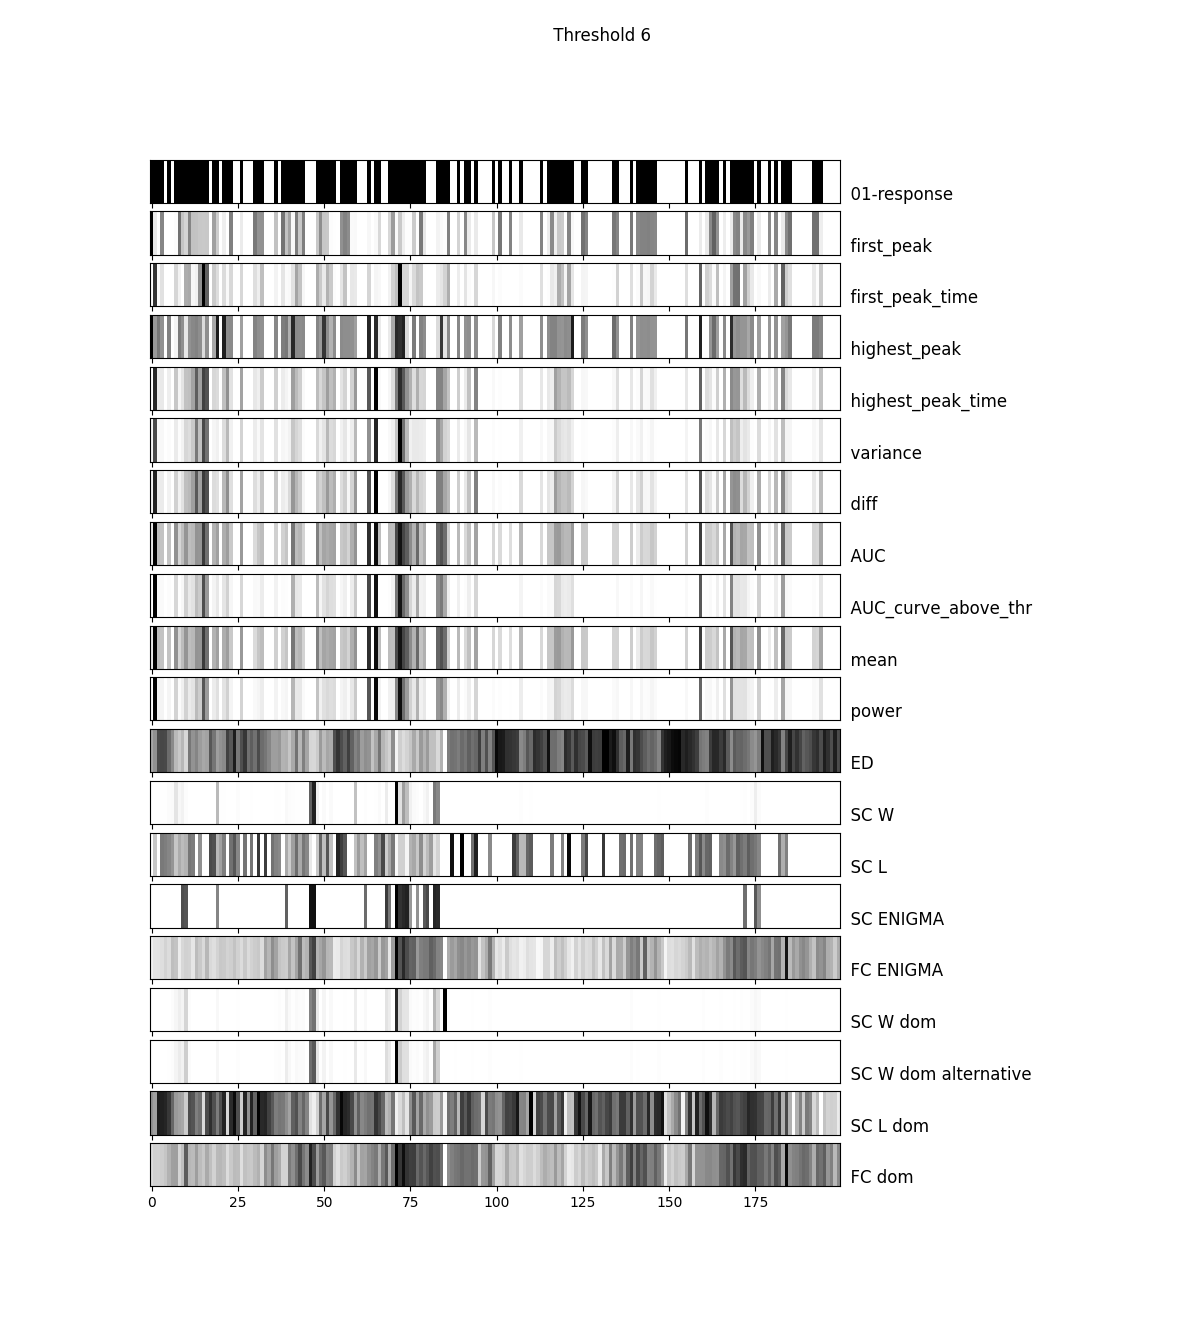

In [16]:
thr = list(responses.keys())[1]
n_of_response_def = len(responses[thr].columns)

fig, axs = prepare_barcode(n_of_response_def+9,200, title = f" Threshold {thr}")

for i,c in enumerate(responses[thr].columns):
    plot_one_barcode(axs[i],responses[thr][c],title=c)

plot_one_barcode(axs[i+1],ED[stim_locatin],title=f"ED")
plot_one_barcode(axs[i+2],SC_W[stim_locatin],title=f"SC W")
plot_one_barcode(axs[i+3],SC_L[stim_locatin],title=f"SC L")
plot_one_barcode(axs[i+4],SC_W_ENIGMA[stim_locatin],title=f"SC ENIGMA")
plot_one_barcode(axs[i+5],FC_ENIGMA[stim_locatin],title=f"FC ENIGMA")
plot_one_barcode(axs[i+6],SC_W_dom[stim_locatin],title=f"SC W dom")
plot_one_barcode(axs[i+7],SC_W_alt[stim_locatin],title=f"SC W dom alternative")
plot_one_barcode(axs[i+8],SC_L_dom[stim_locatin],title=f"SC L dom")
plot_one_barcode(axs[i+9],FC_dom[stim_locatin],title=f"FC dom")

## Correlations

In [17]:
def plot_result(result_df,title=None):
    df_plot = result_df.reset_index().pivot(columns='level_0',index='Y',values='r')
    df_plot_p = result_df.reset_index().pivot(columns='level_0',index='Y',values='p-unc')

    plt.figure()
    ax = sns.heatmap(df_plot.where(df_plot_p < 0.05), annot=True,center=0,cmap='seismic',vmin=-1, vmax=1)
    ax.set_title(title)
    ax.set(xlabel='threshold')

    #plt.savefig(f'../figures/correlations/{empirical_or_simulated}/{title}.png')
    plt.show()


def coor_with_response(X,title=None):
    s = pd.Series(X[stim_locatin])

    dict_by_thr = dict()

    for threshold in thr_range:
        df = responses[threshold]
        df["tested"] = s
        stat_pg = pg.pairwise_corr(df,columns=["tested"],method="spearman").round(3)
        dict_by_thr[threshold] = stat_pg[["Y","r","p-unc"]]

    results = pd.concat(dict_by_thr.values(), keys=dict_by_thr.keys())
    plot_result(results,title=title)

    return results

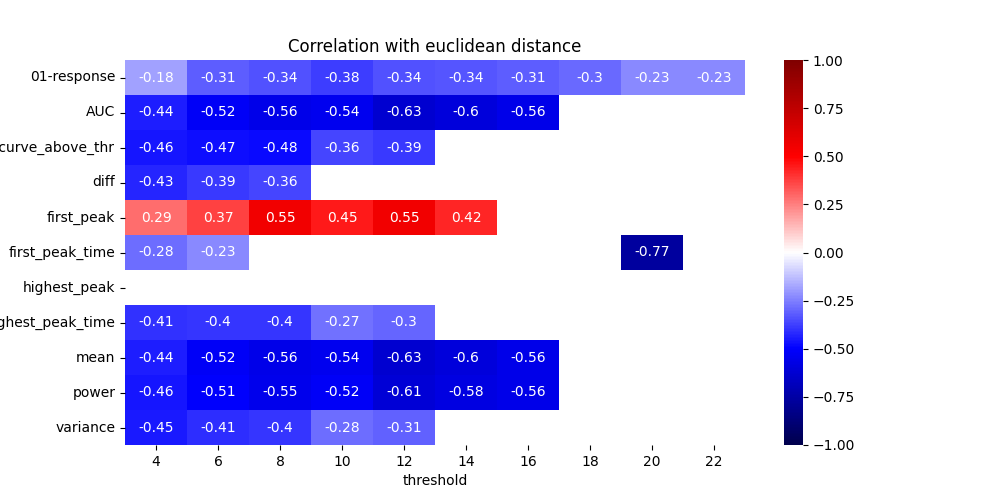

Y      r  p-unc
4  0           01-response -0.183  0.009
   1            first_peak  0.286  0.000
   2       first_peak_time -0.283  0.000
   3          highest_peak  0.089  0.270
   4     highest_peak_time -0.405  0.000
...                    ...    ...    ...
22 6                  diff -0.250  0.516
   7                   AUC -0.133  0.732
   8   AUC_curve_above_thr -0.483  0.187
   9                  mean -0.133  0.732
   10                power -0.133  0.732

[110 rows x 3 columns]

In [18]:
coor_with_response(ED,"Correlation with euclidean distance")

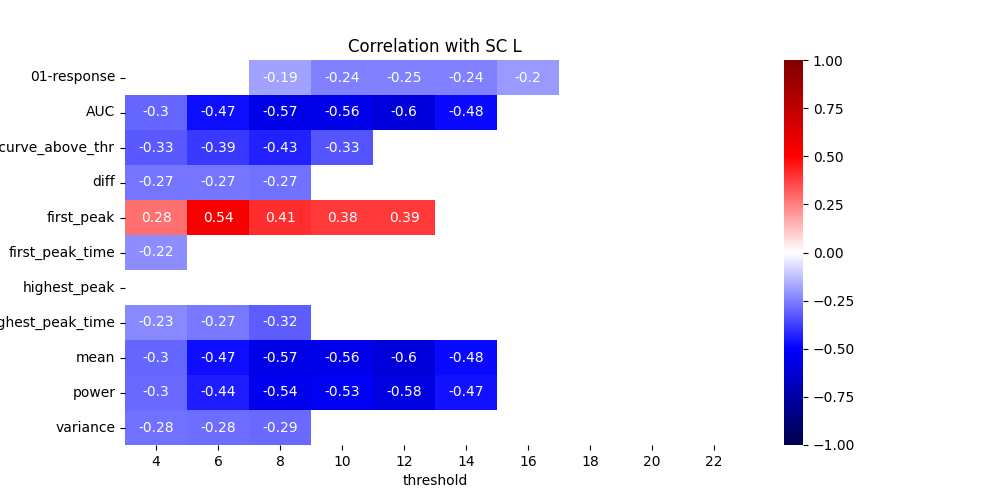

Y      r  p-unc
4  0           01-response -0.183  0.052
   1            first_peak  0.280  0.007
   2       first_peak_time -0.220  0.036
   3          highest_peak  0.146  0.167
   4     highest_peak_time -0.234  0.026
...                    ...    ...    ...
22 6                  diff  0.200  0.747
   7                   AUC  0.100  0.873
   8   AUC_curve_above_thr -0.100  0.873
   9                  mean  0.100  0.873
   10                power  0.100  0.873

[110 rows x 3 columns]

In [19]:
coor_with_response(SC_L,"Correlation with SC L") 


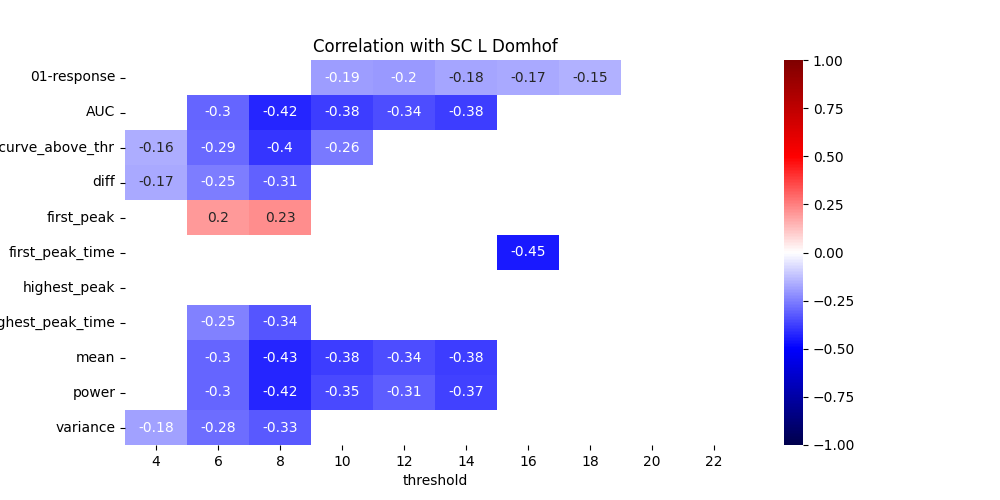

Y      r  p-unc
4  0           01-response -0.071  0.318
   1            first_peak  0.121  0.130
   2       first_peak_time -0.019  0.813
   3          highest_peak -0.026  0.747
   4     highest_peak_time -0.138  0.085
...                    ...    ...    ...
22 6                  diff  0.067  0.865
   7                   AUC -0.067  0.865
   8   AUC_curve_above_thr -0.083  0.831
   9                  mean -0.067  0.865
   10                power -0.067  0.865

[110 rows x 3 columns]

In [20]:
coor_with_response(SC_L_dom,"Correlation with SC L Domhof") 

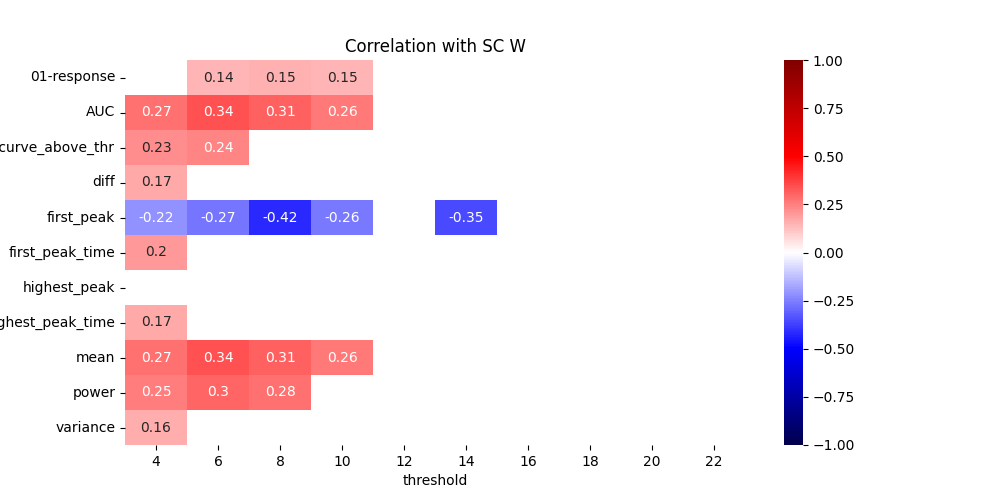

Y      r  p-unc
4  0           01-response  0.099  0.165
   1            first_peak -0.217  0.006
   2       first_peak_time  0.198  0.013
   3          highest_peak -0.116  0.147
   4     highest_peak_time  0.171  0.032
...                    ...    ...    ...
22 6                  diff  0.174  0.654
   7                   AUC  0.313  0.412
   8   AUC_curve_above_thr  0.279  0.468
   9                  mean  0.313  0.412
   10                power  0.313  0.412

[110 rows x 3 columns]

In [21]:
coor_with_response(SC_W,"Correlation with SC W") 

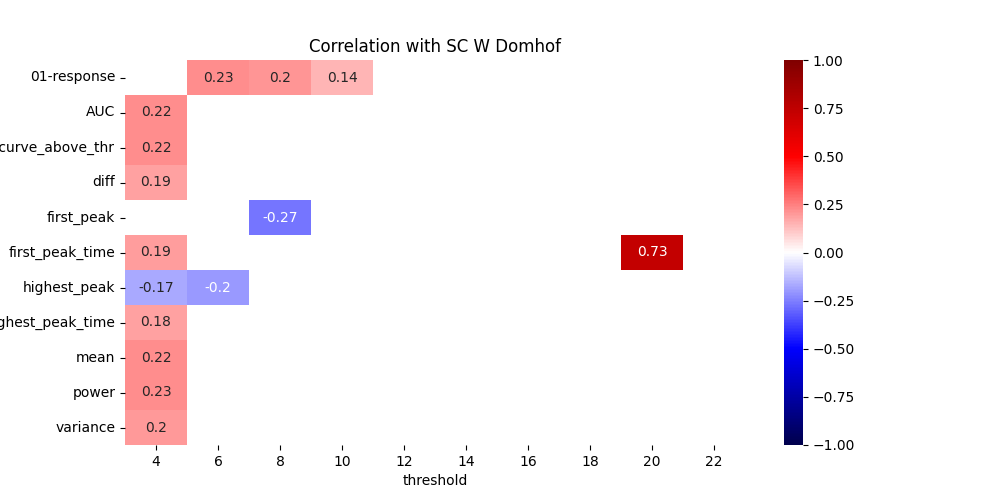

Y      r  p-unc
4  0           01-response  0.115  0.105
   1            first_peak -0.149  0.062
   2       first_peak_time  0.189  0.018
   3          highest_peak -0.168  0.035
   4     highest_peak_time  0.182  0.023
...                    ...    ...    ...
22 6                  diff  0.300  0.433
   7                   AUC  0.133  0.732
   8   AUC_curve_above_thr  0.400  0.286
   9                  mean  0.133  0.732
   10                power  0.133  0.732

[110 rows x 3 columns]

In [22]:
coor_with_response(SC_W_dom,"Correlation with SC W Domhof") 

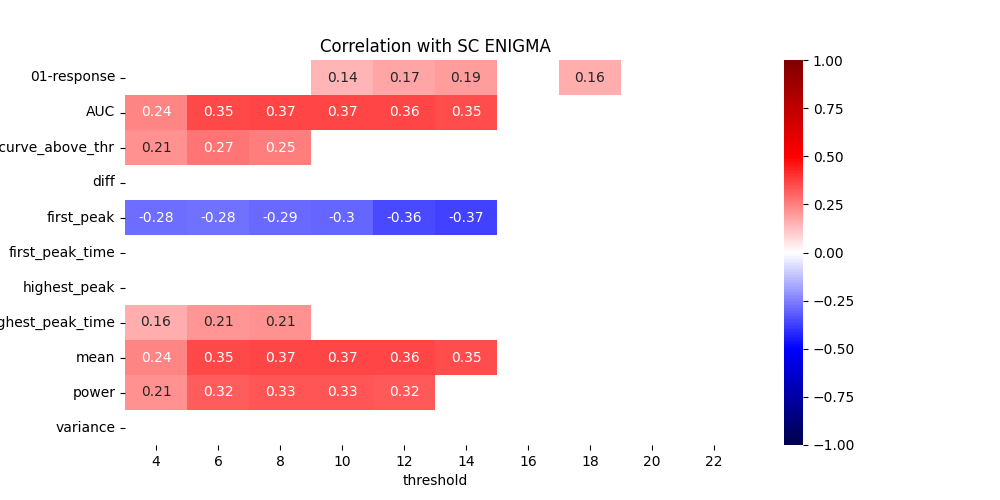

Y      r  p-unc
4  0           01-response  0.060  0.396
   1            first_peak -0.284  0.000
   2       first_peak_time  0.051  0.524
   3          highest_peak -0.129  0.107
   4     highest_peak_time  0.158  0.048
...                    ...    ...    ...
22 6                  diff -0.160  0.681
   7                   AUC -0.046  0.907
   8   AUC_curve_above_thr  0.068  0.861
   9                  mean -0.046  0.907
   10                power -0.046  0.907

[110 rows x 3 columns]

In [23]:
coor_with_response(SC_W_ENIGMA,"Correlation with SC ENIGMA") 

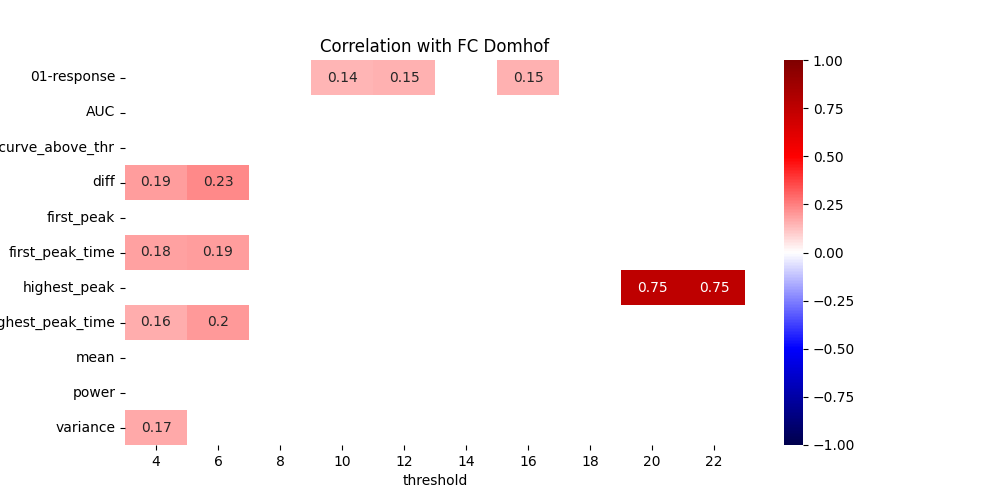

Y      r  p-unc
4  0           01-response  0.012  0.869
   1            first_peak  0.055  0.495
   2       first_peak_time  0.185  0.021
   3          highest_peak -0.040  0.616
   4     highest_peak_time  0.161  0.044
...                    ...    ...    ...
22 6                  diff -0.167  0.668
   7                   AUC -0.017  0.966
   8   AUC_curve_above_thr -0.067  0.865
   9                  mean -0.017  0.966
   10                power -0.017  0.966

[110 rows x 3 columns]

In [24]:
coor_with_response(FC_dom,"Correlation with FC Domhof") 

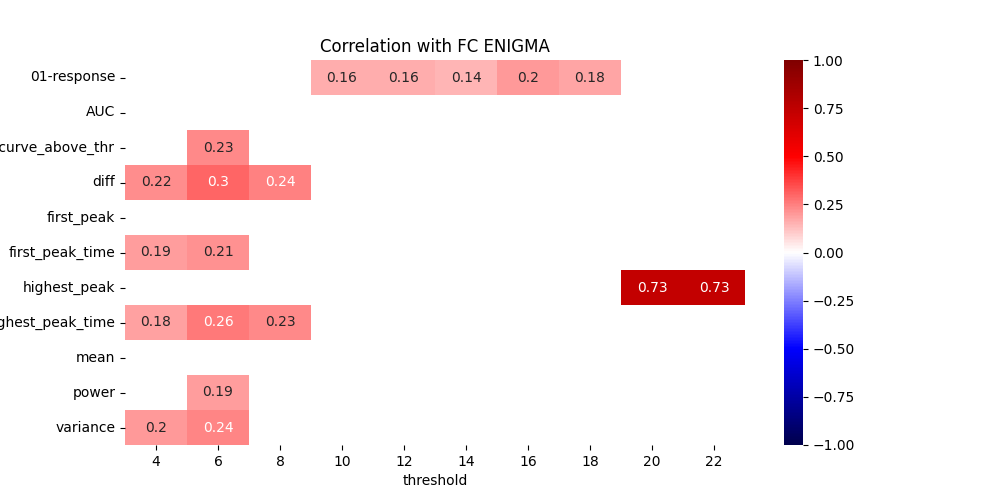

Y      r  p-unc
4  0           01-response -0.013  0.858
   1            first_peak  0.065  0.420
   2       first_peak_time  0.194  0.015
   3          highest_peak  0.003  0.972
   4     highest_peak_time  0.182  0.022
...                    ...    ...    ...
22 6                  diff -0.100  0.798
   7                   AUC  0.000  1.000
   8   AUC_curve_above_thr -0.017  0.966
   9                  mean  0.000  1.000
   10                power  0.000  1.000

[110 rows x 3 columns]

In [25]:
coor_with_response(FC_ENIGMA,"Correlation with FC ENIGMA") 

/tmp/ipykernel_39550/2331860146.py:3: RuntimeWarning: divide by zero encountered in divide
  shorest_path_eff = np.divide(1,shorest_paths)


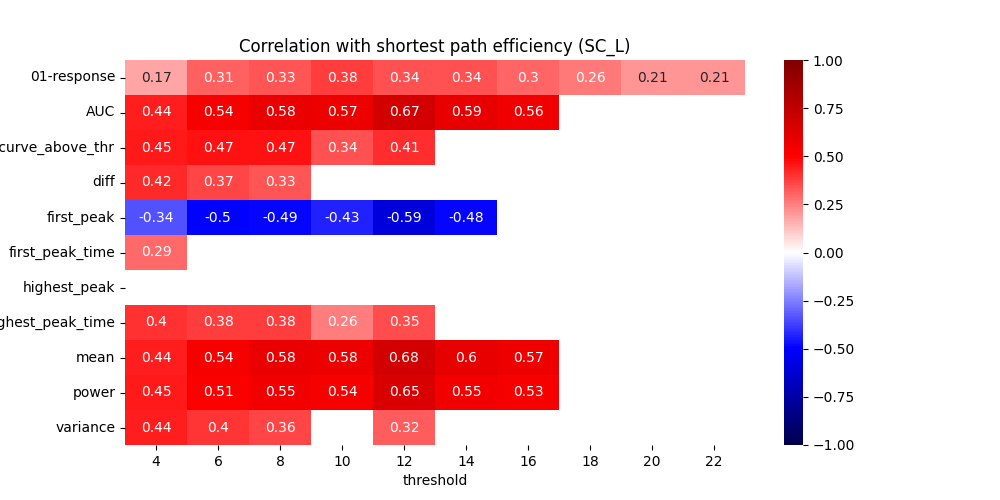

Y      r  p-unc
4  0           01-response  0.174  0.014
   1            first_peak -0.343  0.000
   2       first_peak_time  0.293  0.000
   3          highest_peak -0.101  0.209
   4     highest_peak_time  0.399  0.000
...                    ...    ...    ...
22 6                  diff  0.300  0.433
   7                   AUC  0.550  0.125
   8   AUC_curve_above_thr  0.317  0.406
   9                  mean  0.550  0.125
   10                power  0.550  0.125

[110 rows x 3 columns]

In [26]:
# shortest path efficiency
shorest_paths,_ = metrics.distance_wei_floyd(SC_L)
shorest_path_eff = np.divide(1,shorest_paths) 
# warning because of 0 diagonal, fill diagonal with nans
np.fill_diagonal(shorest_path_eff,np.nan)

coor_with_response(shorest_path_eff,"Correlation with shortest path efficiency (SC_L)")

/tmp/ipykernel_39550/3925107624.py:3: RuntimeWarning: divide by zero encountered in divide
  shorest_path_eff = np.divide(1,shorest_paths)


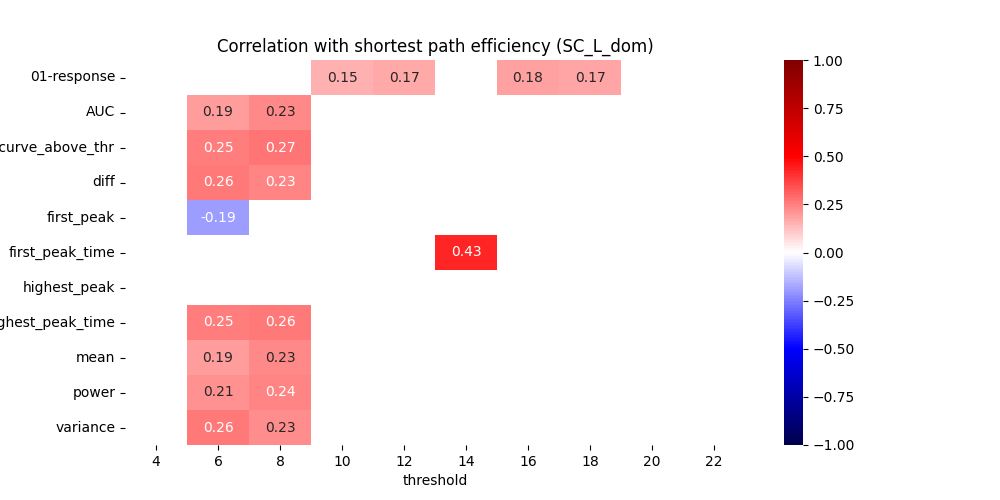

Y      r  p-unc
4  0           01-response  0.082  0.251
   1            first_peak -0.099  0.219
   2       first_peak_time  0.059  0.468
   3          highest_peak -0.028  0.725
   4     highest_peak_time  0.092  0.252
...                    ...    ...    ...
22 6                  diff  0.133  0.732
   7                   AUC  0.300  0.433
   8   AUC_curve_above_thr  0.317  0.406
   9                  mean  0.300  0.433
   10                power  0.300  0.433

[110 rows x 3 columns]

In [27]:
# shortest path efficiency
shorest_paths,_ = metrics.distance_wei_floyd(SC_L_dom)
shorest_path_eff = np.divide(1,shorest_paths)
# warning because of 0 diagonal, fill diagonal with nans
np.fill_diagonal(shorest_path_eff,np.nan)

coor_with_response(shorest_path_eff,"Correlation with shortest path efficiency (SC_L_dom)")

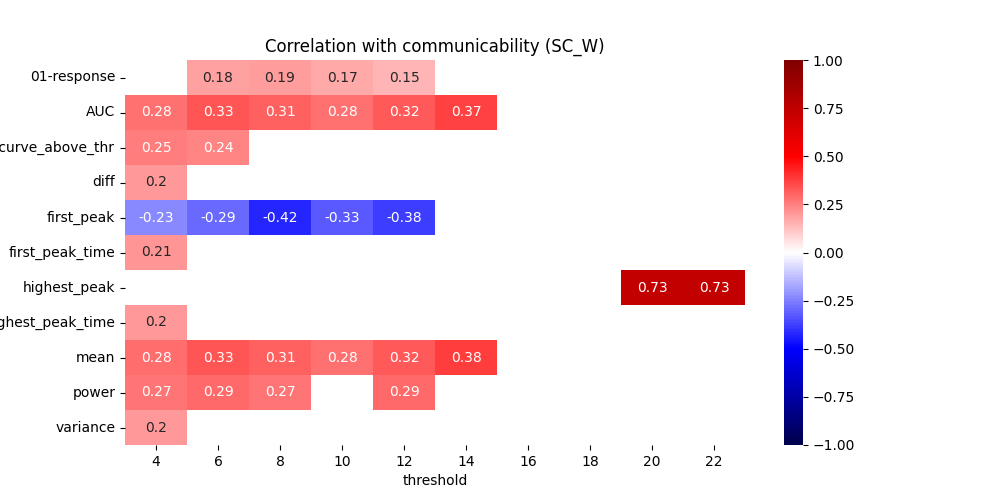

Y      r  p-unc
4  0           01-response  0.126  0.076
   1            first_peak -0.234  0.003
   2       first_peak_time  0.210  0.008
   3          highest_peak -0.149  0.063
   4     highest_peak_time  0.197  0.013
...                    ...    ...    ...
22 6                  diff  0.083  0.831
   7                   AUC  0.283  0.460
   8   AUC_curve_above_thr  0.133  0.732
   9                  mean  0.283  0.460
   10                power  0.283  0.460

[110 rows x 3 columns]

In [28]:
com = metrics.communicability_wei(SC_W)
coor_with_response(com,title="Correlation with communicability (SC_W)")

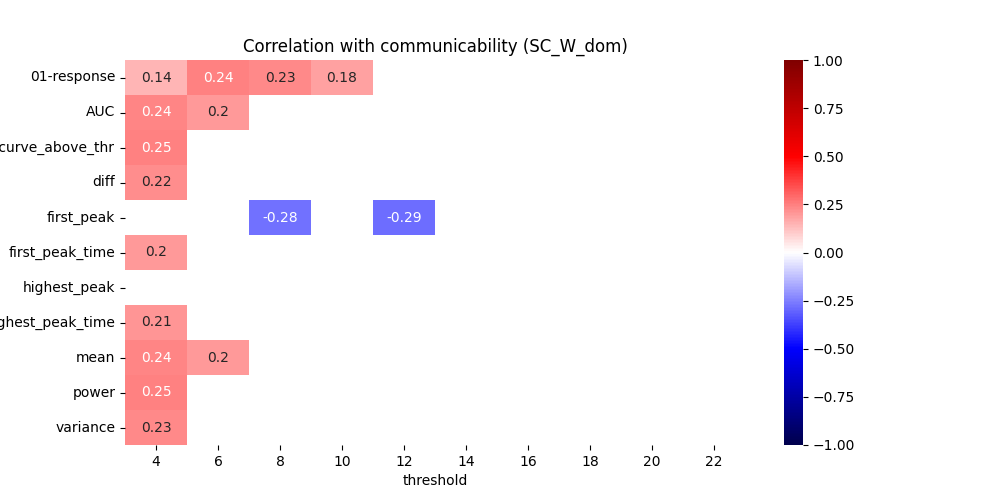

Y      r  p-unc
4  0           01-response  0.143  0.043
   1            first_peak -0.149  0.063
   2       first_peak_time  0.203  0.011
   3          highest_peak -0.134  0.094
   4     highest_peak_time  0.210  0.008
...                    ...    ...    ...
22 6                  diff  0.317  0.406
   7                   AUC  0.250  0.516
   8   AUC_curve_above_thr  0.383  0.308
   9                  mean  0.250  0.516
   10                power  0.250  0.516

[110 rows x 3 columns]

In [29]:
com = metrics.communicability_wei(SC_W_dom)
coor_with_response(com,title="Correlation with communicability (SC_W_dom)")

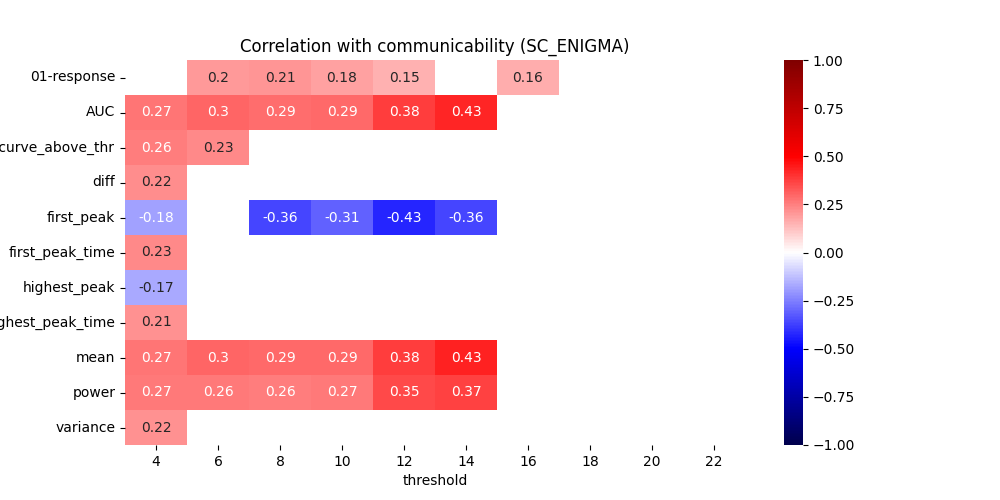

Y      r  p-unc
4  0           01-response  0.135  0.057
   1            first_peak -0.182  0.022
   2       first_peak_time  0.227  0.004
   3          highest_peak -0.167  0.036
   4     highest_peak_time  0.215  0.007
...                    ...    ...    ...
22 6                  diff  0.367  0.332
   7                   AUC  0.583  0.099
   8   AUC_curve_above_thr  0.417  0.265
   9                  mean  0.583  0.099
   10                power  0.583  0.099

[110 rows x 3 columns]

In [30]:
com = metrics.communicability_wei(SC_W_ENIGMA)
coor_with_response(com,title="Correlation with communicability (SC_ENIGMA)")

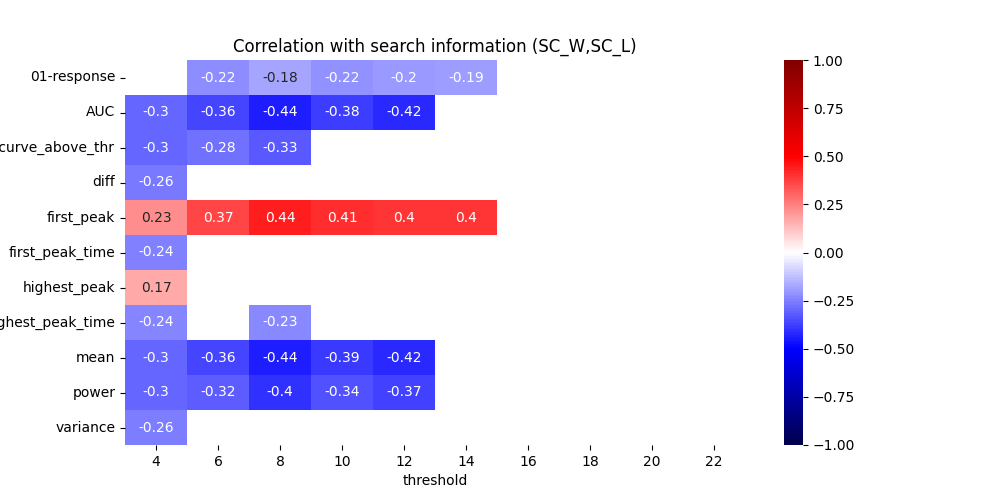

Y      r  p-unc
4  0           01-response -0.108  0.131
   1            first_peak  0.226  0.005
   2       first_peak_time -0.244  0.002
   3          highest_peak  0.171  0.033
   4     highest_peak_time -0.241  0.002
...                    ...    ...    ...
22 6                  diff -0.333  0.381
   7                   AUC -0.533  0.139
   8   AUC_curve_above_thr -0.417  0.265
   9                  mean -0.533  0.139
   10                power -0.533  0.139

[110 rows x 3 columns]

In [31]:
SI = metrics.search_information(SC_W,SC_L)

coor_with_response(SI, title="Correlation with search information (SC_W,SC_L)")

/tmp/ipykernel_39550/3708274183.py:1: RuntimeWarning: divide by zero encountered in divide
  SC_L_ENIGMA = np.where(SC_W_ENIGMA>0,1/SC_W_ENIGMA,np.nan)


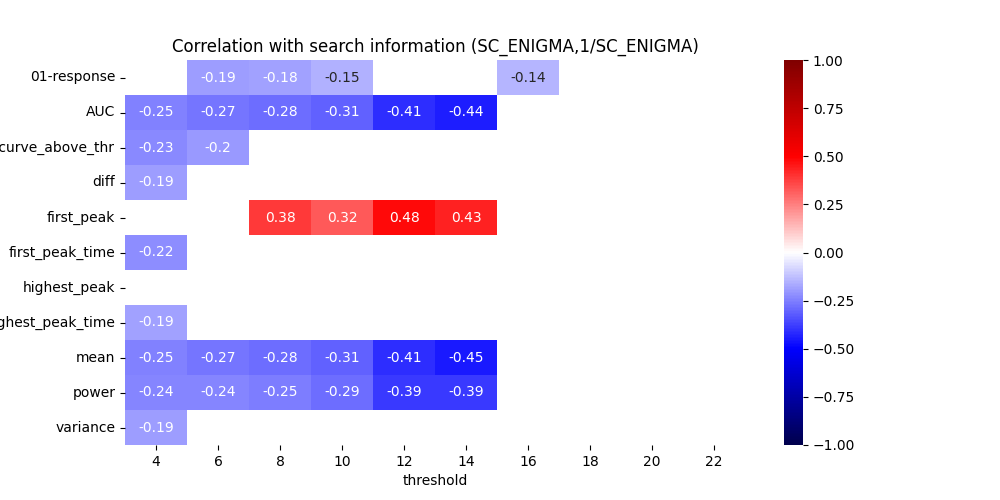

Y      r  p-unc
4  0           01-response -0.130  0.067
   1            first_peak  0.153  0.057
   2       first_peak_time -0.224  0.005
   3          highest_peak  0.156  0.052
   4     highest_peak_time -0.187  0.020
...                    ...    ...    ...
22 6                  diff -0.267  0.488
   7                   AUC -0.517  0.154
   8   AUC_curve_above_thr -0.367  0.332
   9                  mean -0.517  0.154
   10                power -0.517  0.154

[110 rows x 3 columns]

In [32]:
SC_L_ENIGMA = np.where(SC_W_ENIGMA>0,1/SC_W_ENIGMA,np.nan)
SI = metrics.search_information(SC_W_ENIGMA,SC_L_ENIGMA)

coor_with_response(SI, title="Correlation with search information (SC_ENIGMA,1/SC_ENIGMA)")

/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:780: RuntimeWarning: divide by zero encountered in divide
  E_diff = np.divide(1, mfpt)
/tmp/ipykernel_39550/40677678.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


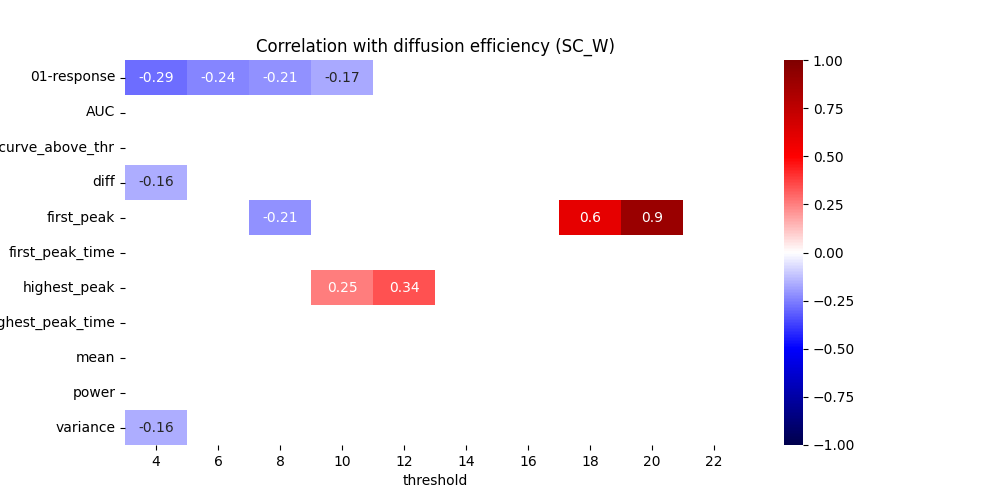

Y      r  p-unc
4  0           01-response -0.286  0.000
   1            first_peak  0.038  0.632
   2       first_peak_time -0.062  0.441
   3          highest_peak  0.058  0.472
   4     highest_peak_time -0.111  0.167
...                    ...    ...    ...
22 6                  diff -0.167  0.668
   7                   AUC -0.133  0.732
   8   AUC_curve_above_thr -0.017  0.966
   9                  mean -0.133  0.732
   10                power -0.133  0.732

[110 rows x 3 columns]

In [33]:
glob_diffusion, diffusion = metrics.diffusion_efficiency(SC_W)

coor_with_response(diffusion, title="Correlation with diffusion efficiency (SC_W)")

/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:780: RuntimeWarning: divide by zero encountered in divide
  E_diff = np.divide(1, mfpt)


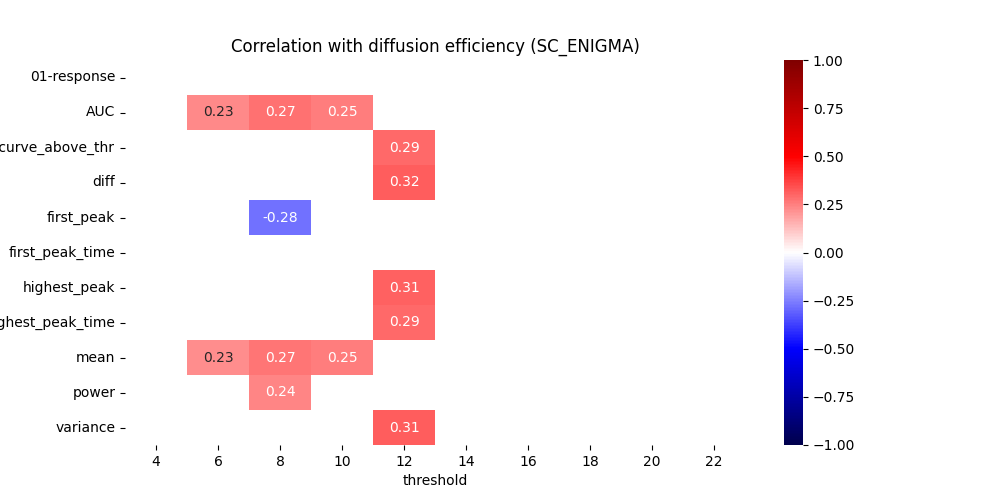

Y      r  p-unc
4  0           01-response -0.127  0.073
   1            first_peak -0.105  0.190
   2       first_peak_time  0.037  0.646
   3          highest_peak  0.020  0.805
   4     highest_peak_time  0.007  0.932
...                    ...    ...    ...
22 6                  diff -0.117  0.765
   7                   AUC  0.183  0.637
   8   AUC_curve_above_thr -0.217  0.576
   9                  mean  0.183  0.637
   10                power  0.183  0.637

[110 rows x 3 columns]

In [34]:
glob_diffusion, diffusion  = metrics.diffusion_efficiency(SC_W_ENIGMA)

coor_with_response(diffusion, title="Correlation with diffusion efficiency (SC_ENIGMA)")

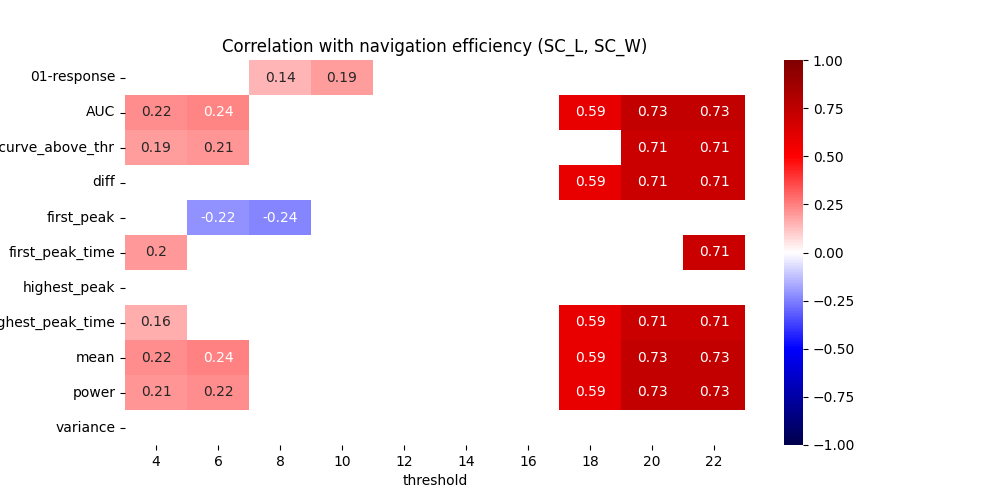

Y      r  p-unc
4  0           01-response  0.039  0.589
   1            first_peak -0.112  0.164
   2       first_peak_time  0.199  0.013
   3          highest_peak  0.017  0.838
   4     highest_peak_time  0.164  0.041
...                    ...    ...    ...
22 6                  diff  0.707  0.033
   7                   AUC  0.730  0.025
   8   AUC_curve_above_thr  0.707  0.033
   9                  mean  0.730  0.025
   10                power  0.730  0.025

[110 rows x 3 columns]

In [35]:
_,_,nav_paths,_,_ = metrics.navigation_wu(SC_L, SC_W)
np.fill_diagonal(nav_paths,np.nan)
nav_eff = np.divide(1,nav_paths)

coor_with_response(nav_eff, title="Correlation with navigation efficiency (SC_L, SC_W)")

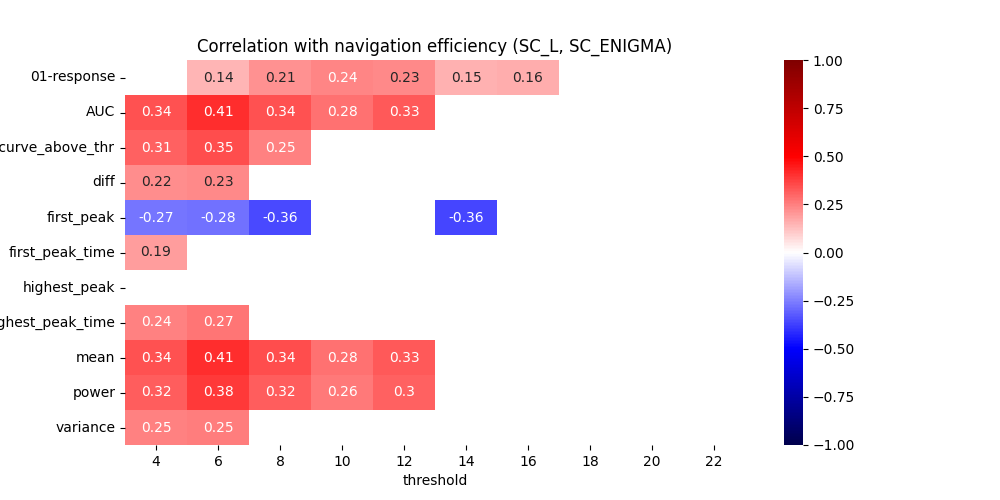

Y      r  p-unc
4  0           01-response  0.074  0.297
   1            first_peak -0.269  0.001
   2       first_peak_time  0.193  0.016
   3          highest_peak -0.006  0.941
   4     highest_peak_time  0.245  0.002
...                    ...    ...    ...
22 6                  diff  0.228  0.556
   7                   AUC  0.248  0.521
   8   AUC_curve_above_thr  0.406  0.278
   9                  mean  0.248  0.521
   10                power  0.248  0.521

[110 rows x 3 columns]

In [36]:
# tady té funkci možná dávám špatný vstup?
_,_,nav_paths,_,_ = metrics.navigation_wu(SC_L, SC_W_ENIGMA)
np.fill_diagonal(nav_paths,np.nan)
nav_eff = np.divide(1,nav_paths)

coor_with_response(nav_eff, title="Correlation with navigation efficiency (SC_L, SC_ENIGMA)")